### 3 layer NN, fully connected, 3*preamble_length node layers, nn.tanh activation - output layer identity preamble_length = 100, channel size = 2
### Generate training data: channels and approximate channel inverses 
### Generate test data: channels and approximate channel inverses

In [45]:
import numpy as np
import scipy.signal as sig
from numpy import linalg as LA
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Create training and test data for the NN

# number of random channels that will be trained and tested on
num_train=500000# 1000000
num_test=10000
SNR = 10

# assume we know the channel_length
channel_length = 2
num_preambles = 1
preamble_length = 100
recieved_length = preamble_length + channel_length - 1

preambles = np.random.randint(0,2,(num_preambles,preamble_length)) 

def add_awgn_noise(signal,SNR_dB):
    """  Adds AWGN noise vector to signal 
         to generate a resulting signal vector y of specified SNR in dB
    """
    L=len(signal)
    SNR = 10**(SNR_dB/10.0) #SNR to linear scale
    Esym=np.sum(np.square(np.abs(signal)))/L #Calculate actual symbol energy
    N0=Esym/SNR; #Find the noise spectral density
    if(isinstance(signal[0], complex)):
        noiseSigma=np.sqrt(N0/2.0)#Standard deviation for AWGN Noise when x is complex
        n = noiseSigma*(np.random.randn(1,L)+1j*np.random.randn(1,L))#computed noise 
    else:
        noiseSigma = np.sqrt(N0);#Standard deviation for AWGN Noise when x is real
        n = noiseSigma*np.random.randn(1,L)#computed noise
    y = signal + n #received signal
    return signal

# channel_train: assume we are working with just real parts, list of all used channels
# preamble_train: use same channel on num_preambles different preambles and store them to train with: 
#               [actual preamble, convolved preamble of same size]
channel_train = np.zeros((num_train,channel_length))
preamble_train = np.zeros((num_train*num_preambles, preamble_length*2))

channel_test = np.zeros((num_test,channel_length))
preamble_test = np.zeros((num_test*num_preambles, preamble_length*2))

In [46]:
# Create data with training data to be [preamble, convolved preamble]

for i in range(0, num_train):
    channel_train[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_train[i])>=1:
        channel_train[i] = channel_train[i]/(sum(channel_train[i]))
        
    for k in range(num_preambles):
        preamble_conv = add_awgn_noise(sig.convolve(preambles[k], channel_train[i], mode='same'), SNR)
        preamble_total = np.hstack((preambles[k], preamble_conv))
        preamble_train[i+k,:] = preamble_total
        
        
for i in range(0, num_test):
    channel_test[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_test[i])>=1:
        channel_test[i] = channel_test[i]/(sum(channel_test[i]))
        
    for k in range(num_preambles):
        preamble_conv = add_awgn_noise(sig.convolve(preambles[k], channel_test[i], mode='same'), SNR)
        preamble_total = np.hstack((preambles[k], preamble_conv))
        preamble_test[i+k,:] = preamble_total


Epoch 0, Cost 0.0813678428530693, Test Cost: 1.0219265222549438
Epoch 10, Cost 0.16996434330940247, Test Cost: 0.033606480807065964
Epoch 20, Cost 0.08418351411819458, Test Cost: 0.048768654465675354
Epoch 30, Cost 0.02376428246498108, Test Cost: 0.026496006175875664
Epoch 40, Cost 0.005893978755921125, Test Cost: 0.010056400671601295
Epoch 50, Cost 0.0020843215752393007, Test Cost: 0.0036772850435227156
Epoch 60, Cost 0.001126085058785975, Test Cost: 0.00138063111808151
Epoch 70, Cost 0.0005337228067219257, Test Cost: 0.00034000413143076
Epoch 80, Cost 0.0001321509771514684, Test Cost: 2.2022657503839582e-05
Epoch 90, Cost 1.1929497304663528e-05, Test Cost: 4.7061312216101214e-05
Epoch 100, Cost 2.8512698918348178e-05, Test Cost: 2.2081940187490545e-05
Epoch 110, Cost 5.749458978243638e-06, Test Cost: 6.08174423177843e-06
Epoch 120, Cost 7.608994110341882e-06, Test Cost: 5.9745630096585955e-06
Epoch 130, Cost 4.6480736273224466e-06, Test Cost: 4.545745468931273e-06
Epoch 140, Cost 4.2

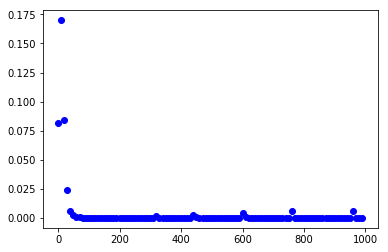

In [93]:
# fix a random seed to have the same results
np.random.seed()

learning_rate = 0.001
epochs = 1000#10000
batch_size = 1000
test_averaging=100
decay = 1 - 10*1e-10

# placeholders for input and output
adaptive_learning_rate = tf.placeholder_with_default(learning_rate, [])
recieved_preamble = tf.placeholder(tf.float32, [None, preamble_length*2])
channel_real = tf.placeholder(tf.float32, [None, channel_length])

layer1 = tf.contrib.layers.fully_connected(recieved_preamble, num_outputs=3*preamble_length, activation_fn=tf.nn.tanh)
#layer2 = tf.contrib.layers.fully_connected(layer1, num_outputs=3*preamble_length, activation_fn=tf.nn.tanh)
layer3 = tf.contrib.layers.fully_connected(layer1, num_outputs=channel_length, activation_fn=tf.identity)

channel_estimate = layer3

cost_fn = tf.reduce_mean(tf.reduce_mean((channel_real-channel_estimate)**2, axis=1))
optimizer = tf.train.AdamOptimizer(learning_rate=adaptive_learning_rate).minimize(cost_fn)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
plt.figure()

test_costs =[]
test_channels = []
train_costs = []
train_channels =[]

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        
        # for each batch start the batch with passing the first preamble through the identity channel
        identity_channel = np.zeros(channel_length)
        identity_channel[0] = 1
        preamble_conv_id = sig.convolve(preambles[0], identity_channel, mode='same')
        preamble_batch = np.hstack((preambles[0], preamble_conv_id))
        
        real_channel_batch = identity_channel
        
        for rand in range(0,batch_size-1):
            rand_int = np.random.randint(0,num_train*num_preambles)
            preamble_batch = np.vstack((preamble_batch, preamble_train[rand_int]))
            real_channel_batch = np.vstack((real_channel_batch, channel_train[rand_int]))
            
        preamble_batch.reshape((batch_size, preamble_length*2))
        real_channel_batch.reshape((batch_size, channel_length))
        
        _,cost,channel_est = sess.run(
            [optimizer, cost_fn, channel_estimate], 
            feed_dict={recieved_preamble: preamble_batch, 
                       channel_real: real_channel_batch ,adaptive_learning_rate: learning_rate * (decay**epoch)})
        
        train_costs.append(cost)
        train_channels.append(channel_est)
        
        if epoch % 10 == 0: 
            plt.plot(epoch, cost, 'bo')
            mc_cost, mc_channel = sess.run(
                [cost_fn, channel_estimate], feed_dict={recieved_preamble: preamble_test, channel_real: channel_test})
            print('Epoch {}, Cost {}, Test Cost: {}'.format(epoch, cost, mc_cost))
            test_costs.append(mc_cost)
            test_channels.append(mc_channel)
            
    saved_model = saver.save(sess, 'my-test-model')

Text(0,0.5,'Log Cost on Training set')

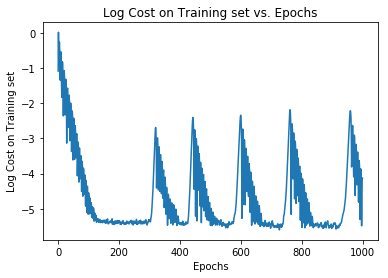

In [94]:
plt.plot(np.log10(train_costs))
plt.title("Log Cost on Training set vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Log Cost on Training set")

Text(0,0.5,'Log Cost on Test set')

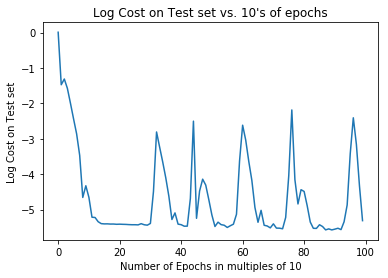

In [95]:
plt.plot(np.log10(test_costs))
plt.title("Log Cost on Test set vs. 10's of epochs")
plt.xlabel("Number of Epochs in multiples of 10")
plt.ylabel("Log Cost on Test set")

In [96]:
print(test_costs)

[1.0219265, 0.033606481, 0.048768654, 0.026496006, 0.010056401, 0.003677285, 0.0013806311, 0.00034000413, 2.2022658e-05, 4.7061312e-05, 2.208194e-05, 6.0817442e-06, 5.974563e-06, 4.5457455e-06, 4.0094751e-06, 3.9386455e-06, 3.9510628e-06, 3.8963849e-06, 3.904669e-06, 3.8395137e-06, 3.8684216e-06, 3.8340813e-06, 3.8117958e-06, 3.7619077e-06, 3.7320265e-06, 3.732267e-06, 3.6970832e-06, 3.9946244e-06, 3.7248294e-06, 3.6275155e-06, 4.0583282e-06, 3.2570548e-05, 0.0015577624, 0.00058368087, 0.00022242097, 7.8918463e-05, 2.3985474e-05, 5.2431592e-06, 8.0605105e-06, 3.8796893e-06, 3.7452921e-06, 3.3933788e-06, 3.4040331e-06, 2.0659445e-05, 0.0031465674, 5.6690842e-06, 3.3451681e-05, 7.2250034e-05, 4.9192007e-05, 1.9061559e-05, 7.0360802e-06, 3.3245403e-06, 4.4122708e-06, 3.7540844e-06, 3.6120116e-06, 3.1276859e-06, 3.4951038e-06, 3.8659268e-06, 7.3652291e-06, 0.00023654096, 0.0024172137, 0.00092332839, 0.00022961598, 6.6622219e-05, 1.1483846e-05, 4.3739624e-06, 9.5149326e-06, 3.6021427e-06, 3

In [97]:
print(np.log10(test_costs))

[ 0.00941967 -1.47357702 -1.31185925 -1.57681954 -1.9975574  -2.4344728
 -2.85992241 -3.46851587 -4.65713024 -4.32733583 -4.65596294 -5.21597195
 -5.22369385 -5.34239483 -5.39691257 -5.40465307 -5.40328598 -5.409338
 -5.40841579 -5.4157238  -5.41246605 -5.41633844 -5.41887045 -5.42459202
 -5.42805529 -5.42802715 -5.43214083 -5.39852428 -5.42889357 -5.44039059
 -5.39165306 -4.48717499 -2.80749869 -3.23382449 -3.65282416 -4.10282135
 -4.62005186 -5.28040695 -5.09363747 -5.41120291 -5.42651415 -5.4693675
 -5.46800613 -4.68488121 -2.50216293 -5.24648714 -4.47558212 -4.14116192
 -4.30810547 -4.71984148 -5.15266943 -5.47826862 -5.35533762 -5.4254961
 -5.44225073 -5.50477695 -5.45654011 -5.41274643 -5.13281393 -3.62609363
 -2.61668491 -3.03464389 -3.63899779 -4.17638111 -4.9399128  -5.35912514
 -5.02159405 -5.44343901 -5.4633646  -5.51676083 -5.40366268 -5.5241251
 -5.52557278 -5.54225683 -5.22274256 -4.04679346 -2.18538713 -4.15336561
 -4.84121323 -4.43847084 -4.48806572 -4.89165068 -5.35227

In [98]:
print(channel_test[90:100])

[[ 0.28024751  0.38640331]
 [ 0.77082471  0.22917529]
 [ 0.35787932  0.64212068]
 [ 0.40791355  0.59208645]
 [ 0.46698483  0.53301517]
 [ 0.77556583  0.22443417]
 [ 0.5005834   0.41316206]
 [ 0.59574332  0.40425668]
 [ 0.4217953   0.5782047 ]
 [ 0.23616665  0.33127582]]


In [99]:
print(test_channels[85][90:100])

[[ 0.27969655  0.38768277]
 [ 0.77035403  0.23072353]
 [ 0.35719618  0.64410299]
 [ 0.40689811  0.59413022]
 [ 0.46605232  0.53478211]
 [ 0.77500868  0.22608304]
 [ 0.50360817  0.41548803]
 [ 0.59575516  0.4049899 ]
 [ 0.42076048  0.58021176]
 [ 0.23091057  0.3306689 ]]
